In [1]:
import kagglehub
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt
import json
from tqdm import tqdm

c:\Users\stani\Documents\Code\Python\HIN\UN-number-detection\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
distribution = [('train', 0.8), ('test', 0.1), ('val', 0.1)]
len(distribution)

3

In [3]:
path = kagglehub.dataset_download("stanislavlevendeev/hazmat-detection")
video_directory = os.environ["PATH_TO_DATA"]
print("Path to dataset files:", path)
print("Path to video files:", video_directory)

Path to dataset files: C:\Users\stani\.cache\kagglehub\datasets\stanislavlevendeev\hazmat-detection\versions\13
Path to video files: C:/Users/stani/Documents/WagonVideos


In [4]:
df = pd.read_csv(path + "/labels_dataframe.csv")
videos = df["Source"].unique()
videos

array(['1690279852.mp4', '1690281365.mp4', '1692830440.mp4',
       '1690801380.mp4', '1691487366.mp4', '1692875102.mp4',
       '1692945482.mp4', '1693811855.mp4', '1693954819.mp4',
       '1693805101.mp4', '1693820172.mp4', '1692787289.mp4',
       '1691496786.mp4', '1692872075.mp4', '1693308534.mp4',
       '1693308657.mp4', '1693309263.mp4', '1693820241.mp4',
       '1693820504.mp4', '1693820904.mp4', '1696009577.mp4',
       '1696374314.mp4', '1696416413.mp4', '1696441496.mp4'], dtype=object)

In [5]:
available_videos = os.listdir(video_directory)
available_videos = [video for video in available_videos if video.endswith(".mp4")]
available_videos = [video for video in available_videos if video in videos]
available_videos

['1690281365.mp4', '1692830440.mp4', '1696009577.mp4']

In [6]:
total_frames = df[df["Source"].isin(available_videos)]
total_frames = total_frames["Absolute Frame"].count()
total_frames

np.int64(950)

In [7]:
frames_path = "./data/data_faster_rcnn"

In [8]:
def save_frame(frame, video, frame_number, path, subpath, overwrite=True):
    """
    Save a frame to disk with a formatted filename.

    Args:
        frame (numpy.ndarray): The frame to save.
        video (str): The name of the video file (without extension).
        frame_number (int): The frame number.
        path (str): The directory to save the frame.
        overwrite (bool): Whether to overwrite existing files.
    """
    new_path = os.path.join(path, subpath, "images")
    os.makedirs(new_path, exist_ok=True)
    formatted_frame_number = f"{frame_number:05d}"
    image_path = f"{new_path}/{video}_{formatted_frame_number}.jpg"
    # print(f"🎞️ Saving frame {image_path}...")
    if not overwrite and os.path.exists(image_path):
        return
    cv2.imwrite(image_path, frame)


coco_categories = [
    {
        "id": 1,
        "name": "hazmat",
    }
]
coco_images = {"train": [], "test": [], "val": []}
coco_annotations = {"train": [], "test": [], "val": []}


def add_annotation(video, dist, frame_number, video_h, video_w, annotations):
    global coco_annotations
    global coco_images
    global coco_categories
    image_id = len(coco_images[dist]) + 1
    if dist not in coco_images:
        coco_images[dist] = []
    coco_images[dist].append(
        {
            "id": image_id,
            "file_name": f"{video}_{frame_number:05d}.jpg",
            "width": video_w,
            "height": video_h,
        }
    )
    for index, annotation in annotations.iterrows():
        x_left_top = annotation["XTL"]
        y_left_top = annotation["YTL"]
        x_right_bottom = annotation["XBR"]
        y_right_bottom = annotation["YBR"]
        # get the bounding box
        width = x_right_bottom - x_left_top
        height = y_right_bottom - y_left_top
        # calculate the area
        area = width * height
        # make the bbox
        bbox = [x_left_top, y_left_top, width, height]
        if dist not in coco_annotations:
            coco_annotations[dist] = []
        coco_annotations[dist].append(
            {
                "id": len(coco_annotations) + 1,
                "image_id": image_id,
                "category_id": 1,
                "bbox": bbox,
                "area": area,
                "iscrowd": 0,
            }
        )


def get_rnd_distribution():
    new_dist = distribution.copy()
    while len(new_dist) > 0:
        rnd_dist = random.choice(new_dist)
        required_amount = int(total_frames * rnd_dist[1])
        if rnd_dist[0] not in coco_annotations:
            coco_annotations[rnd_dist[0]] = []
        if required_amount > len(rnd_dist[0]):
            return rnd_dist
        else:
            new_dist.remove(rnd_dist)
    print("WHAT THE HELL IS GOING ON?")
    return None

In [9]:
with tqdm(total=total_frames) as pbar:
    for video in available_videos:
        video_path = f"{video_directory}/{video}"
        cap = cv2.VideoCapture(video_path)
        video_w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        video_h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        number_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_number = 0
        video_name = video.split('.')[0]
        while frame_number < number_frames:
            ret, frame = cap.read()
            pbar.set_description(f"Processing {video}, frame {frame_number}/{number_frames}")
            if not ret:
                break
            annotations = df[(df["Source"] == video) & (df["Relative Frame"] == frame_number)]
            if not annotations.empty:
                sub_path = get_rnd_distribution()[0]
                # take rnd distribution if not full and then store in it.
                save_frame(frame, video_name, frame_number, frames_path,sub_path)
                add_annotation(video_name, sub_path, frame_number, video_h, video_w, annotations)
                pbar.update(annotations.shape[0])
            frame_number += 1
        cap.release()

Processing 1696009577.mp4, frame 4639/4640: 100%|██████████| 950/950 [04:44<00:00,  3.34it/s] 


In [10]:
for name, dist in distribution:
    path = f"{frames_path}/{name}/annotations"
    os.makedirs(path, exist_ok=True)
    with open(f"{frames_path}/{name}/annotations/instances_{name}.json", "w") as f:
        json.dump(
            {
                "images": coco_images[name],
                "annotations": coco_annotations[name],
                "categories": coco_categories,
            },
            f,
        )

In [11]:
def draw_annotations(annotation,dist_name):
    # coco_images is array of dictionaries with keys: id, file_name, width, height
    image_name = [
        image["file_name"]
        for image in coco_images[dist_name]
        if image["id"] == annotation["image_id"]
    ]
    # open the image
    image = cv2.imread(f"{frames_path}/{dist_name}/{image_name}/{image_name[0]}")
    # get the bbox
    bbox = annotation["bbox"]
    # draw the bbox
    x, y, w, h = bbox
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    # show the image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


def get_random_annotation():
    dist_name = random.choice(distribution)[0]
    return random.choice(coco_annotations[dist_name]), dist_name
# check if all the images are in the right folder


Checking train


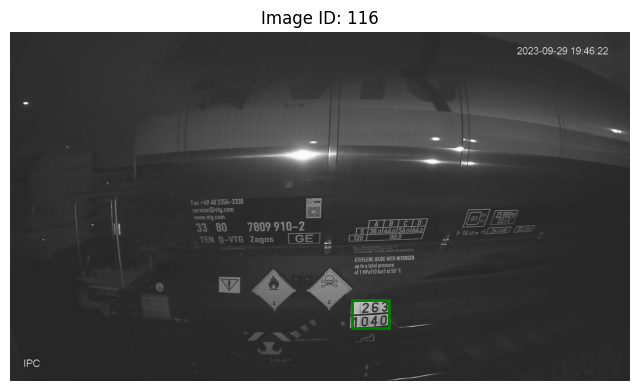

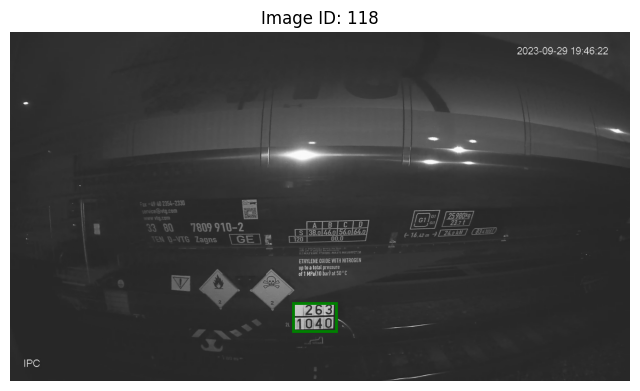

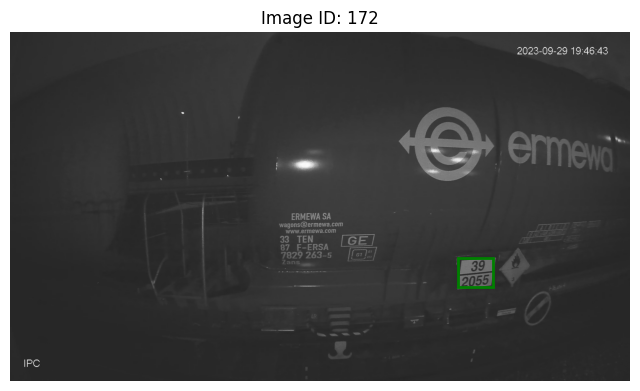

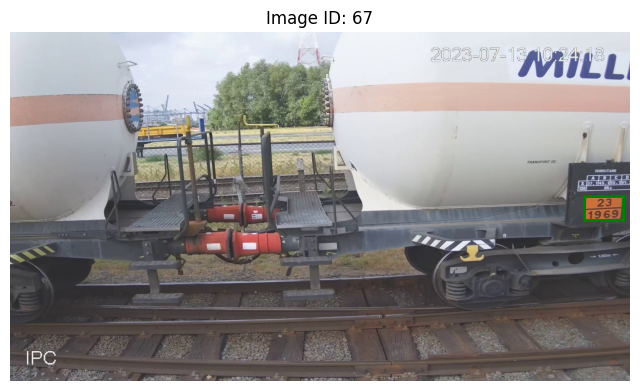

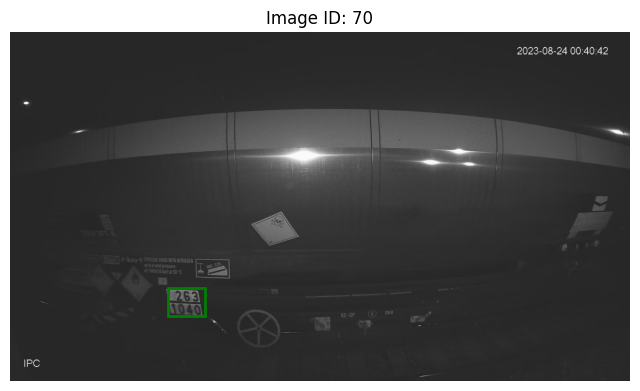

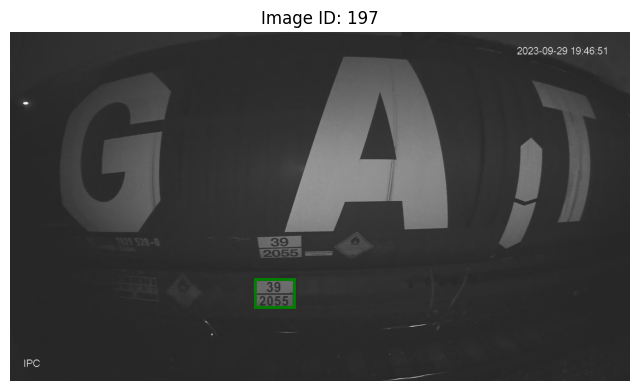

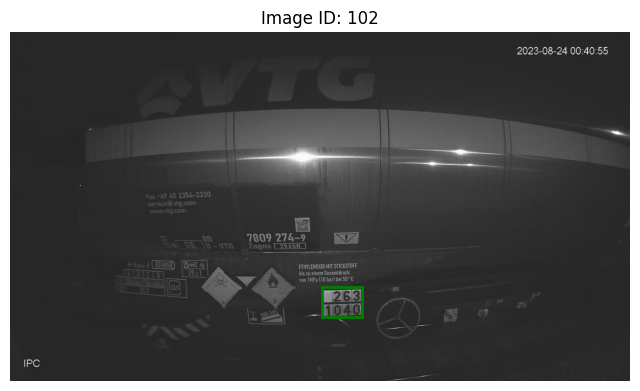

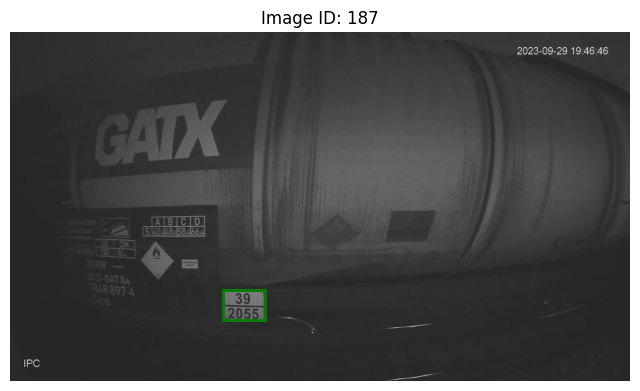

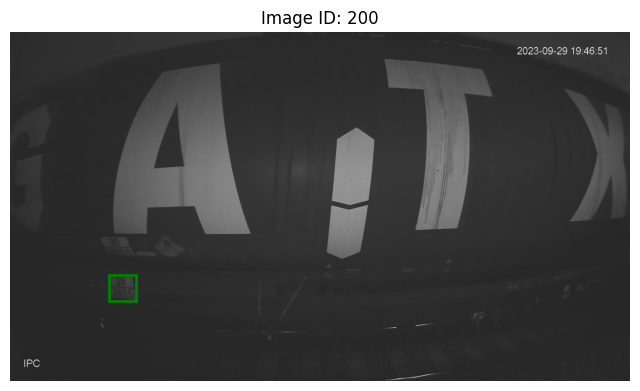

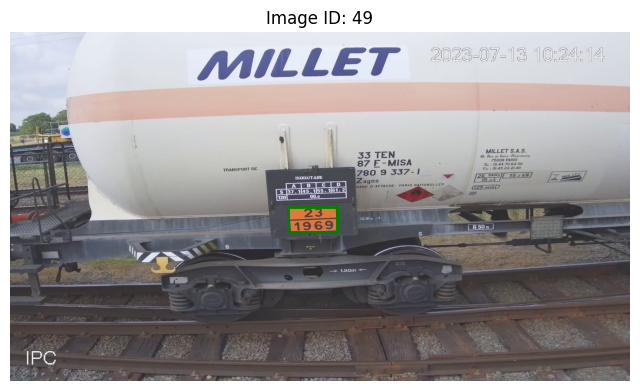

Checking test


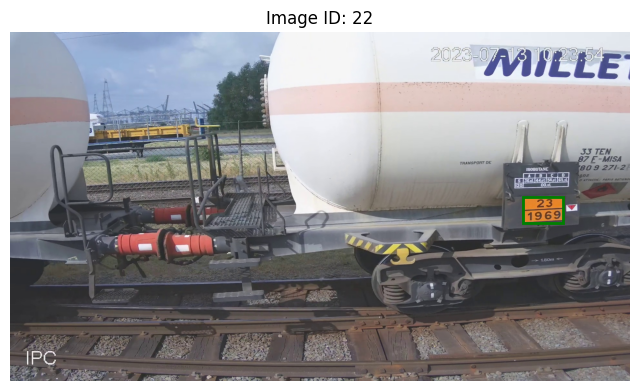

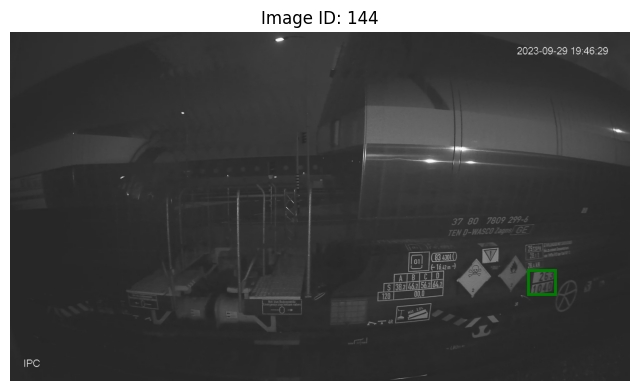

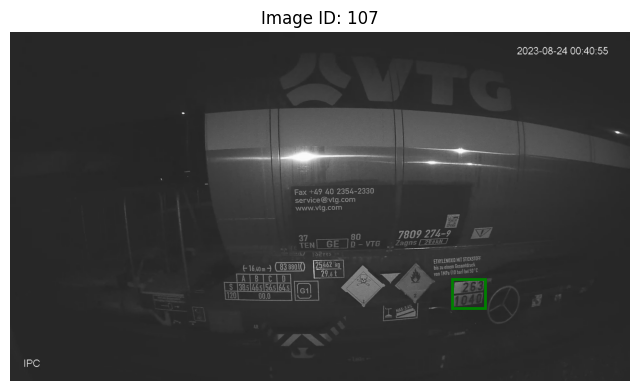

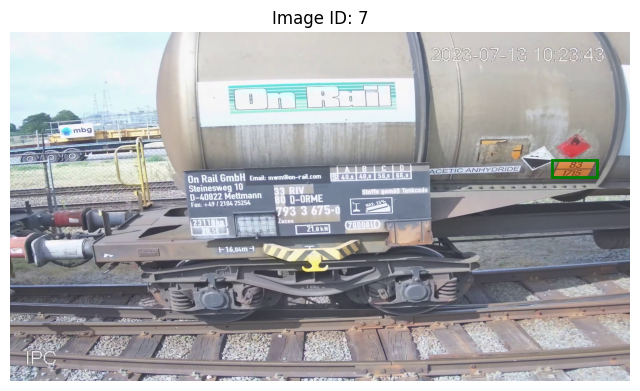

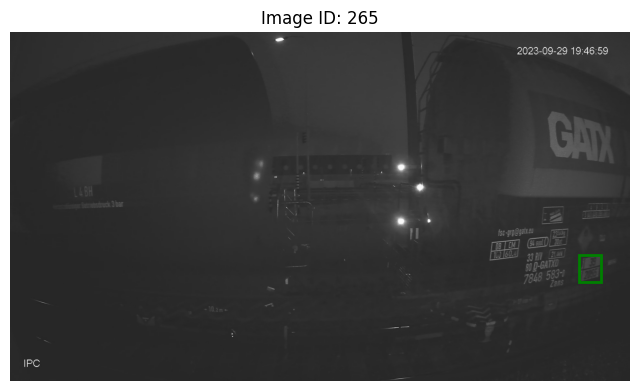

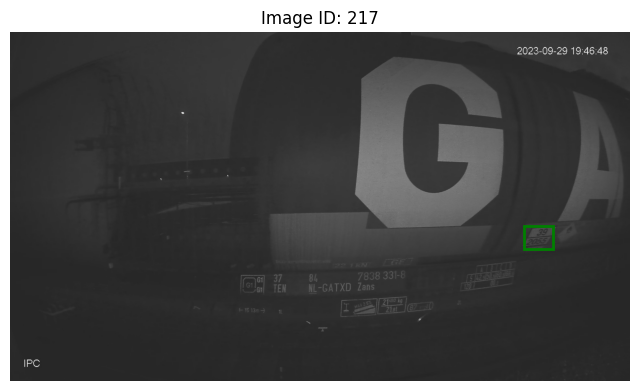

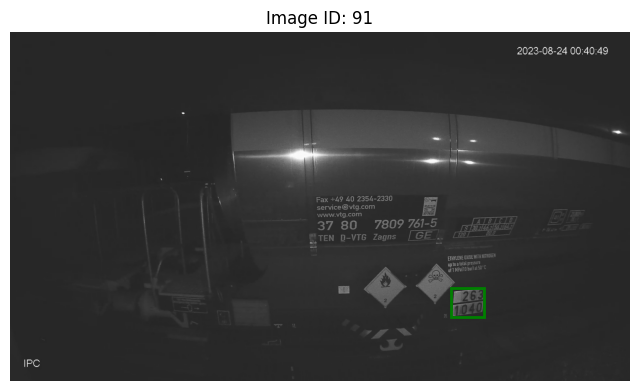

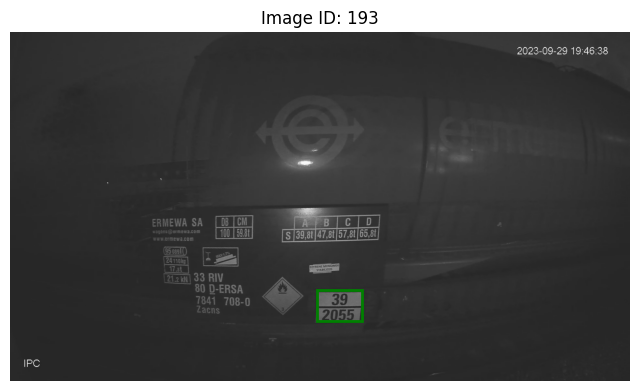

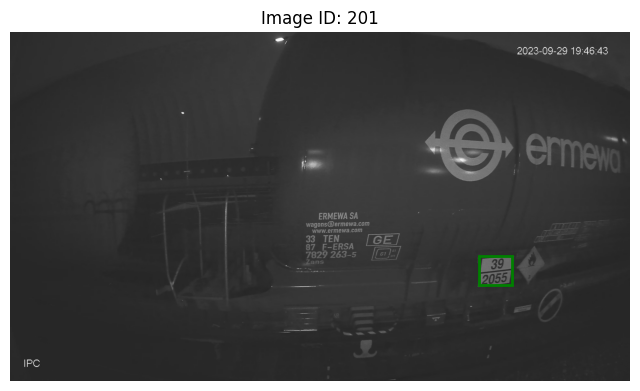

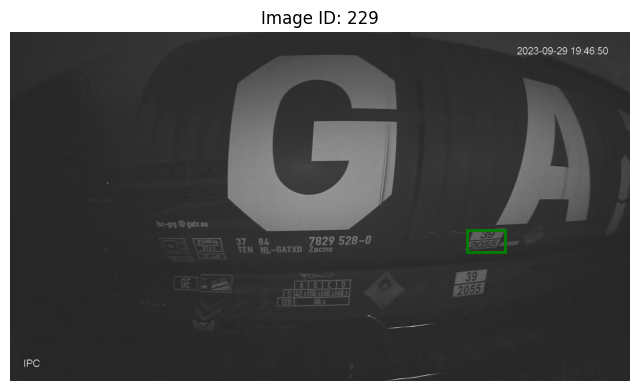

Checking val


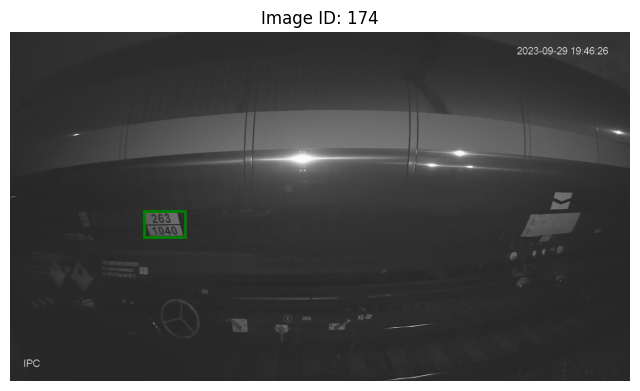

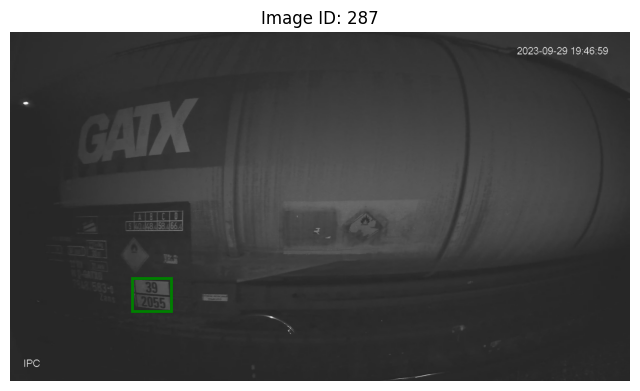

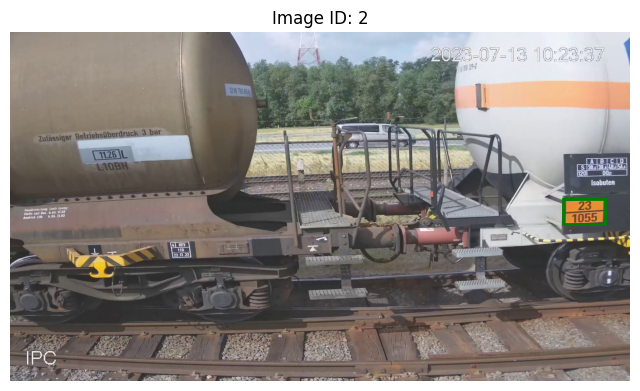

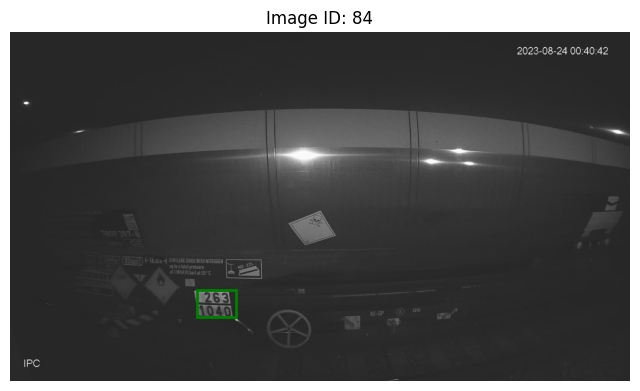

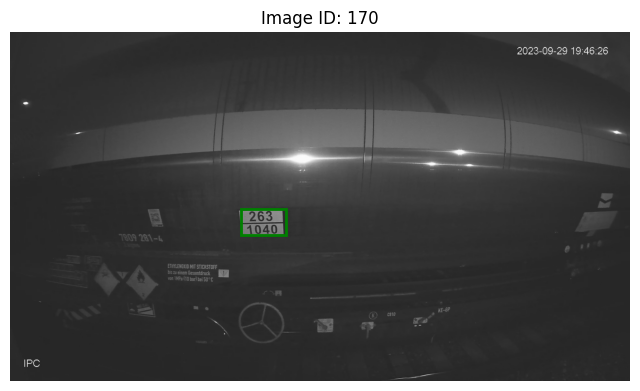

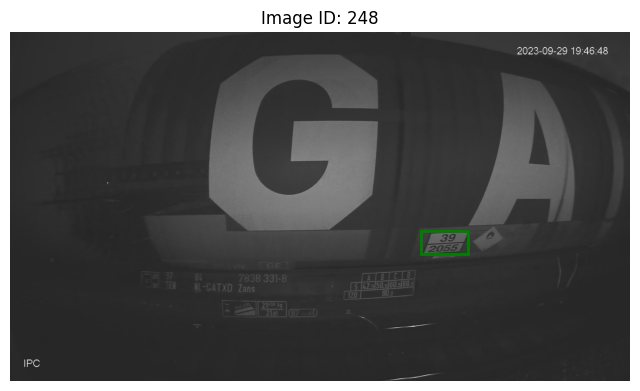

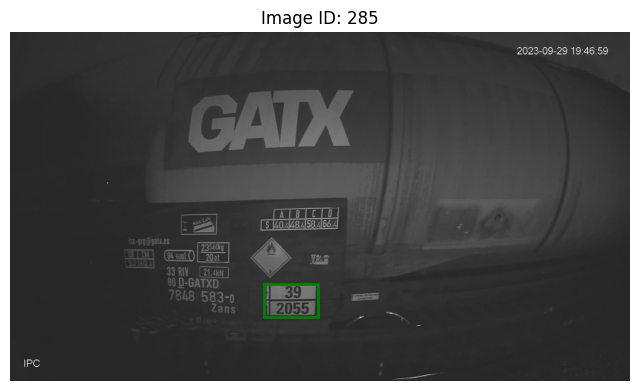

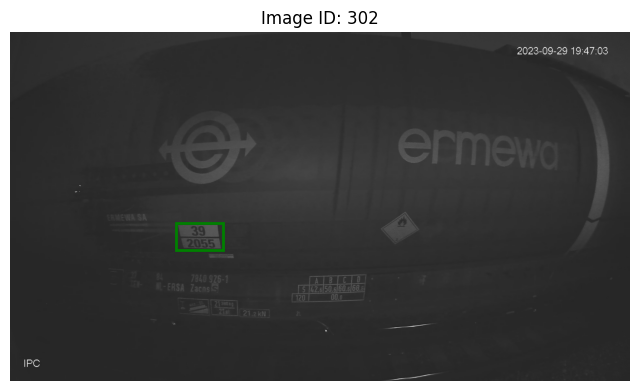

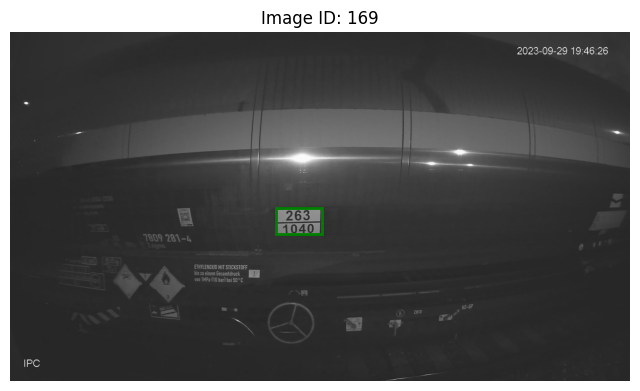

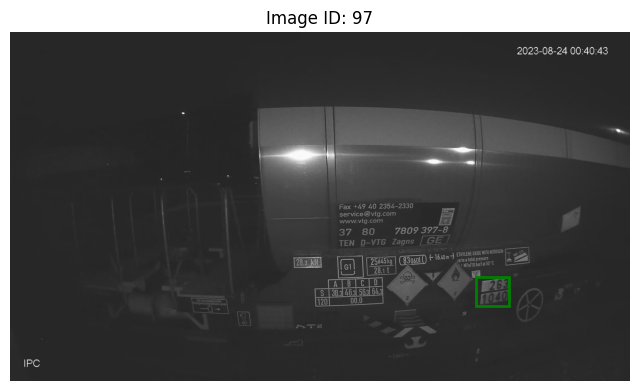

In [15]:

# read the json files
def check_images_in_annotations(destination_dir, destination_dir_for_images, max_images=10):
    with open(destination_dir) as f:
        data = json.load(f)
        annotations = data["annotations"]
        #shffle
        random.shuffle(annotations)
        for annotation in annotations[:max_images]:
            image_id = annotation["image_id"]
            images = data["images"]
            image = next((image for image in images if image["id"] == image_id), None)

            if image is None:
                print(f"Image not found for annotation: {annotation}")
            else:
                # show the image with bounding box
                # Read the image
                path_im = destination_dir_for_images + "/"+ image["file_name"]
                image = cv2.imread(path_im)
                if image is None:
                    print(f"Image not found: {path_im}")
                    continue

                # Convert BGR (OpenCV format) to RGB (Matplotlib format)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Extract bounding box coordinates
                x, y, w, h = annotation["bbox"]
                x, y, w, h = int(x), int(y), int(w), int(h)

                # Plot the image
                plt.figure(figsize=(8, 8))
                plt.imshow(image)

                # Draw the bounding box
                plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='green', facecolor='none', linewidth=2))

                # Display the image with the bounding box
                plt.title(f"Image ID: {image_id}")
                plt.axis("off")
                plt.show()

for name, dist in distribution:
    print(f"Checking {name}")
    check_images_in_annotations(
        frames_path + f"/{name}/annotations/instances_{name}.json", 
        frames_path + f"/{name}/images")


In [13]:
get,dist_name = get_random_annotation()
print(get,dist_name)
draw_annotations(get,dist_name)

{'id': 4, 'image_id': 297, 'category_id': 1, 'bbox': [592.6, 1132.3, 221.29999999999995, 153.87000000000012], 'area': 34051.43100000002, 'iscrowd': 0} val


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt1'. Sequence item with index 0 has a wrong type
>  - Can't parse 'rec'. Expected sequence length 4, got 2
>  - Can't parse 'rec'. Expected sequence length 4, got 2
